In [36]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

0       420.157651
1       541.411707
2       901.157457
3       639.080229
4       750.875606
          ...     
230     440.517424
231     541.200597
232     581.359892
233     743.077243
234    1057.676711
Name: income, Length: 204, dtype: float64

                         QuantReg Regression Results                          
Dep. Variable:                foodexp   Pseudo R-squared:               0.5994
Model:                       QuantReg   Bandwidth:                       57.24
Method:                 Least Squares   Sparsity:                        179.1
Date:                Thu, 14 Mar 2024   No. Observations:                  204
Time:                        12:31:02   Df Residuals:                      202
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     57.5591     20.657      2.786      0.006      16.829      98.290
income         0.5913      0.024     24.964      0.000       0.545       0.638

The condition number is large, 2.87e+03. This might indicate that there are
strong multicollinearity or other numerical problems.


Text(0, 0.5, 'Food expenditure')

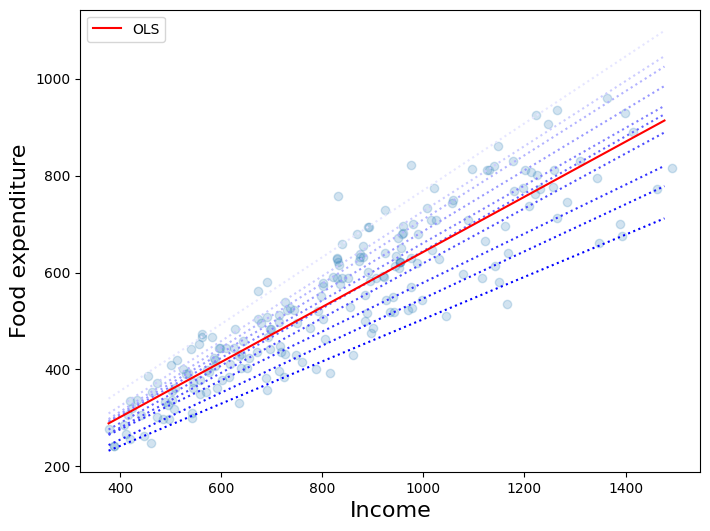

In [37]:
mod = smf.quantreg("foodexp ~ income", data)
res = mod.fit(q=0.5)
print(res.summary())

quantiles = np.arange(0.05, 0.96, 0.1)

def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params["Intercept"], res.params["income"]] + res.conf_int().loc[
        "income"
    ].tolist()


models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=["q", "a", "b", "lb", "ub"])

ols = smf.ols("foodexp ~ income", data).fit()
ols_ci = ols.conf_int().loc["income"].tolist()
ols = dict(
    a=ols.params["Intercept"], b=ols.params["income"], lb=ols_ci[0], ub=ols_ci[1]
)

print(models)
print(ols)

x = np.arange(data.income.min(), data.income.max(), 50)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    col = 1.0/models.shape[0] * i
    ax.plot(x, y, linestyle="dotted", color=(col, col, 1))

y = get_y(ols["a"], ols["b"])

ax.plot(x, y, color="red", label="OLS")
ax.scatter(data.income, data.foodexp, alpha=0.2)
legend = ax.legend()
ax.set_xlabel("Income", fontsize=16)
ax.set_ylabel("Food expenditure", fontsize=16)

In [38]:
import jax
import jax.numpy as jnp

kappa = 1
num_tau_samples = 64
num_tau_prime_samples = 64

def huber_quantile_loss(chosen_action_quantile_values, target_quantile_vals, quantiles):
    """
    chosen_action_logits is batch x n_quantiles x 1
    target is same
    
    """
    # Shape of bellman_errors and huber_loss:
    # batch_size x num_tau_prime_samples x num_tau_samples x 1.
    bellman_errors = (target_quantile_vals[:, :, None, :] -
                      chosen_action_quantile_values[:, None, :, :])
    # The huber loss (see Section 2.3 of the paper) is defined via two cases:
    # case_one: |bellman_errors| <= kappa
    # case_two: |bellman_errors| > kappa
    huber_loss_case_one = (
        (jnp.abs(bellman_errors) <= kappa).astype(jnp.float32) *
        0.5 * bellman_errors ** 2)
    huber_loss_case_two = (
        (jnp.abs(bellman_errors) > kappa).astype(jnp.float32) *
        kappa * (jnp.abs(bellman_errors) - 0.5 * kappa))
    huber_loss = huber_loss_case_one + huber_loss_case_two
    # Tile by num_tau_prime_samples along a new dimension. Shape is now
    # batch_size x num_tau_prime_samples x num_tau_samples x 1.
    # These quantiles will be used for computation of the quantile huber loss
    # below (see section 2.3 of the paper).
    quantiles = jnp.tile(quantiles[:, None, :, :],
                         [1, num_tau_prime_samples, 1, 1]).astype(jnp.float32)
    # Shape: batch_size x num_tau_prime_samples x num_tau_samples x 1.
    quantile_huber_loss = (jnp.abs(quantiles - jax.lax.stop_gradient(
        (bellman_errors < 0).astype(jnp.float32))) * huber_loss) / kappa
    # Sum over current quantile value (num_tau_samples) dimension,
    # average over target quantile value (num_tau_prime_samples) dimension.
    # Shape: batch_size x num_tau_prime_samples x 1.
    loss = jnp.sum(quantile_huber_loss, axis=2)
    loss = jnp.mean(loss, axis=1)
    return jnp.mean(loss)

In [39]:
from jax import random
from flax import linen as nn


model = nn.Dense(features=1)

@jax.jit
def mse(params, x_batched, y_batched):
  # Define the squared loss for a single pair (x,y)
  def squared_error(x, y):
    pred = model.apply(params, x)
    return jnp.inner(y-pred, y-pred) / 2.0
  # Vectorize the previous to compute the average of the loss on all samples.
  return jnp.mean(jax.vmap(squared_error)(x_batched,y_batched), axis=0)


def train_model(loss):
    key1, key2 = random.split(random.key(0))
    x = jnp.array(data.income)[:, None]
    y = jnp.array(data.foodexp)[:, None]
    params = model.init(key2, x[0]) # Initialization call
    
    learning_rate = 0.3  # Gradient step size.
    import optax
    tx = optax.adam(learning_rate=learning_rate)
    opt_state = tx.init(params)
    loss_grad_fn = jax.value_and_grad(loss)
    for i in range(101):
      loss_val, grads = loss_grad_fn(params, x, y)
      updates, opt_state = tx.update(grads, opt_state)
      params = optax.apply_updates(params, updates)
      if i % 10 == 0:
        print('Loss step {}: '.format(i), loss_val)
    return params

In [47]:
@jax.jit
def huber_quantile(params, x_batched, y_batched):
    def error(x, y):
        pred = model.apply(params, x)
        return huber_quantile_loss(pred, y)
    return jnp.mean(jax.vmap(error)(x_batched, y_batched))

Loss step 0:  817030.94
Loss step 10:  142717.31
Loss step 20:  16156.444
Loss step 30:  3231.769
Loss step 40:  5630.0645
Loss step 50:  4850.214
Loss step 60:  3741.4067
Loss step 70:  3183.5027
Loss step 80:  2963.07
Loss step 90:  2881.025
Loss step 100:  2850.751


Text(0, 0.5, 'Food expenditure')

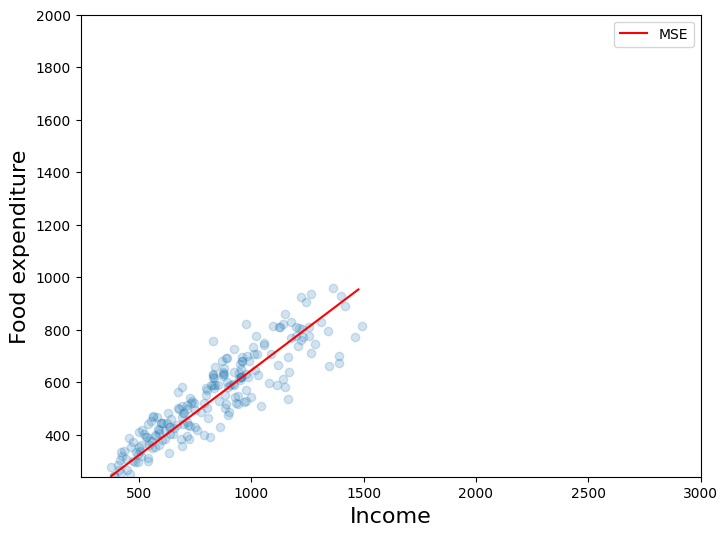

In [41]:
mse_params = train_model(mse)
x = jnp.arange(data.income.min(), data.income.max(), 50)[:, None]

fig, ax = plt.subplots(figsize=(8, 6))

y_mse = jax.vmap(lambda a: model.apply(mse_params, a))(x)

ax.scatter(data.income, data.foodexp, alpha=0.2)

ax.plot(x, y_mse, color="red", label="MSE")
ax.legend()
ax.set_xlabel("Income", fontsize=16)
ax.set_ylabel("Food expenditure", fontsize=16)

In [45]:
from dopamine.discrete_domains import atari_lib


class ImplicitQuantileNetwork(nn.Module):
  """The Implicit Quantile Network (Dabney et al., 2018).."""
  quantile_embedding_dim: int

  @nn.compact
  def __call__(self, x, num_quantiles, rng):
    initializer = nn.initializers.variance_scaling(
        scale=1.0 / jnp.sqrt(3.0),
        mode='fan_in',
        distribution='uniform')
    state_vector_length = x.shape[-1]
    state_net_tiled = jnp.tile(x, [num_quantiles, 1])
    quantiles_shape = [num_quantiles, 1]
    quantiles = jax.random.uniform(rng, shape=quantiles_shape)
    quantile_net = jnp.tile(quantiles, [1, self.quantile_embedding_dim])
    quantile_net = (
        jnp.arange(1, self.quantile_embedding_dim + 1, 1).astype(jnp.float32)
        * np.pi
        * quantile_net)
    quantile_net = jnp.cos(quantile_net)
    quantile_net = nn.Dense(features=state_vector_length,
                            kernel_init=initializer)(quantile_net)
    quantile_net = nn.relu(quantile_net)
    x = state_net_tiled * quantile_net
    x = nn.Dense(features=512, kernel_init=initializer)(x)
    x = nn.relu(x)
    quantile_values = nn.Dense(features=1,
                               kernel_init=initializer)(x)
    return atari_lib.ImplicitQuantileNetworkType(quantile_values, quantiles)


In [46]:
network_def = ImplicitQuantileNetwork(quantile_embedding_dim=16)
batch_size = x.shape[0]
def loss_fn(params, rng_input, target_quantile_vals):
    def online(state, key):
      return network_def.apply(params, state, num_quantiles=num_tau_samples,
                               rng=key)
    
    batched_rng = jnp.stack(jax.random.split(rng_input, num=batch_size))
    model_output = jax.vmap(online)(x, batched_rng)
    quantile_values = model_output.quantile_values
    quantiles = model_output.quantiles
    chosen_action_quantile_values = quantile_values
    # Shape of bellman_erors and huber_loss:
    # batch_size x num_tau_prime_samples x num_tau_samples x 1.
    bellman_errors = (target_quantile_vals[:, :, None, :] -
                      chosen_action_quantile_values[:, None, :, :])
    # The huber loss (see Section 2.3 of the paper) is defined via two cases:
    # case_one: |bellman_errors| <= kappa
    # case_two: |bellman_errors| > kappa
    huber_loss_case_one = (
        (jnp.abs(bellman_errors) <= kappa).astype(jnp.float32) *
        0.5 * bellman_errors ** 2)
    huber_loss_case_two = (
        (jnp.abs(bellman_errors) > kappa).astype(jnp.float32) *
        kappa * (jnp.abs(bellman_errors) - 0.5 * kappa))
    huber_loss = huber_loss_case_one + huber_loss_case_two
    # Tile by num_tau_prime_samples along a new dimension. Shape is now
    # batch_size x num_tau_prime_samples x num_tau_samples x 1.
    # These quantiles will be used for computation of the quantile huber loss
    # below (see section 2.3 of the paper).
    quantiles = jnp.tile(quantiles[:, None, :, :],
                         [1, num_tau_prime_samples, 1, 1]).astype(jnp.float32)
    # Shape: batch_size x num_tau_prime_samples x num_tau_samples x 1.
    quantile_huber_loss = (jnp.abs(quantiles - jax.lax.stop_gradient(
        (bellman_errors < 0).astype(jnp.float32))) * huber_loss) / kappa
    # Sum over current quantile value (num_tau_samples) dimension,
    # average over target quantile value (num_tau_prime_samples) dimension.
    # Shape: batch_size x num_tau_prime_samples x 1.
    loss = jnp.sum(quantile_huber_loss, axis=2)
    loss = jnp.mean(loss, axis=1)
    return jnp.mean(loss)

In [ ]:
def train_quantile_model(loss):
    key1, key2 = random.split(random.key(0))
    x = jnp.array(data.income)[:, None]
    y = jnp.array(data.foodexp)[:, None]
    params = network_def.init(key2, x[0]) # Initialization call
    
    learning_rate = 0.3  # Gradient step size.
    import optax
    tx = optax.adam(learning_rate=learning_rate)
    opt_state = tx.init(params)
    loss_grad_fn = jax.value_and_grad(loss)
    for i in range(101):
      loss_val, grads = loss_grad_fn(params, x, y)
      updates, opt_state = tx.update(grads, opt_state)
      params = optax.apply_updates(params, updates)
      if i % 10 == 0:
        print('Loss step {}: '.format(i), loss_val)
    return params

train_quantile_model(get_huber_quantile_loss)